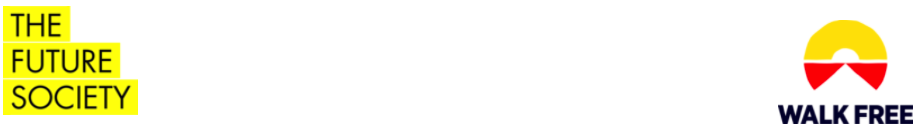

#*Project AIMS (AI against Modern Slavery)*

---




##💻 Note: You can run this notebook locally or on Google Colab following this [link](https://drive.google.com/file/d/1I_SjEEVedonAxo8ZprKZ0FHTyPulsTQS/view?usp=sharing).



# Business Performance Indicators
## Has the company reviewed the business key performance indicators (KPIs) to ensure they are not increasing the risk of modern slavery?
 
This task aims to use weak supervision by using the Snorkel package to label statements that indicate that the company is reviewing its Business KPIs to ensure that they are not increasing the risk of modern slavery. Business Key Performance Indicators (KPIs) can affect the level of risk and expose the company to the risk of modern slavery incidents. 
 
For example, the expansion of a production company in a country with many migrant workers can likely increase the chance of happening modern slavery incidents. Companies can provide information in their MSA report statement regarding their current business KPIs. They can explain if they have considered whether these KPIs make their businesses and supply chains more or less vulnerable to modern slavery. Some of these KPIs are :


*   Expansion of companies that have a lot of migrant workers
* Turn-around time of a business operation
*The cost of materials
*Efficiency in production
*Sourcing the goods in the shortest amount of time



 
 
For more information, please review[ WikiRate’s research on MSA Business Performance Indicators](https://wikirate.org/Walk_Free_Foundation+MSA_Business_Performance_Indicators) or  [Home Office Guidance, pp. 36.](https://www.gov.uk/government/uploads/system/uploads/attachment_data/file/471996/Transparency_in_Supply_Chains_etc__A_practical_guide__final_.pdf)
 
 
 
 
 
### Labelled dataset
When creating the labelled dataset, if the company discloses any of the above or related KPIs in relation to their negative impact on modern slavery, the annotators labelled the statements with 'Yes' value and provided details in Comments. If the company indicates it is planning to identify these KPIs in the future, the annotators labelled the statements with 'In Development'' and included any relevant details in the Comments. If no such KPIs exist or are described in the statement, they selected 'No'.
 
 



In [ ]:
#!pip install snorkel
#!pip install unidecode
#!pip install contractions
#!pip install eli5

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/ProjectAIMS

/content/drive/.shortcut-targets-by-id/11tRyVLvElSSvedZDsiP76NndaI3wNyFb/Project AIMS


## Setup

Data preprocessing is performed before applying the labelling function based on the keywords, including removing empty text values, empty metric values, duplicate data rows, lemmatisation, etc.

After the pre-processing, it is clear that the data is highly imbalanced. Out of the total 1285 labelled statements, there are 1083 which have a ‘No’ label associated with them which means that either the companies do not disclose anything about the reviewing of the existing KPIs or no such KPIs exist. Only 120 statements have a ‘Yes’ label associated with them, indicating that only 120 companies are reviewing the existing KPIs to ensure they are safe from exposure to modern slavery. Also, 82 statements have an ‘In Development’, meaning that the company is planning to identify such KPIs in the near future.

To make this auto-labelling task easier, binary encoding of the label takes place where the statements with label values as ‘No’, ‘In development’ and ‘In development, No’ are encoded as 0, and the statements which have a ‘Yes’ label associated are encoded as 1.

The keywords considered for the labelling function (e.g. ‘Business KPI’, ‘cheapest goods’, ‘sourcing the cheapest goods in the shortest amount of time’) need some preprocessing before being used in the creation of a labelling function. This pre-processing includes tasks such as lemmatisation, tense checking etc.

After all the pre-processing, the final set of the keywords which are considered in the labeling functions’ creation are: 'business kpi', 'business kpis', 'cheap good', 'cost material', 'efficiency production', 'key performance indicator', 'kpi', 'performance indicator', 'source cheap good short time', 'turn time'.
 
The next step is to check how many of the above keywords are present in the statements’ sentences and extract them into a single list for each sentence. The new feature named ‘Extract’ is maintained, which has a subset of the keywords present in the sentence from the above-mentioned ones. This is done by parsing and searching the sentences using the Spacy package for the keywords and then extracting them into a special list. 
 
Once the labelling function is created, if the extract list is empty, then that sentence is labelled as 0; otherwise, it is labelled as 1. This is done by using Snorkel weak supervision labelling task. This task uses many functions present In the Snorkel package, such as  LFAnalysis, MajorityLabelVoter, etc. LFAnalysis function is used to understand the different metrics like coverage, polarity and check for the conflicts in the result. MajorityLabelVoter is used to perform the classification task to predict the label.

The output of the system is a prediction about whether a sentence could be classified as containing relevant information about the Business Key Performance Indicators or not. 


In [ ]:
from snorkel.labeling import labeling_function
from snorkel.labeling.model import LabelModel
from snorkel.labeling import LabelingFunction
from snorkel.labeling import PandasLFApplier
from snorkel.labeling import LFAnalysis
from snorkel.labeling.model import MajorityLabelVoter
import spacy
import en_core_web_sm
import pandas as pd
import re
import tqdm
import snorkel
import nltk 
from nltk import word_tokenize, pos_tag
from utils import sentencizer, evaluation_rb
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

nlp = en_core_web_sm.load()

#from modern_slavery_dataset.sentencizer import custom_sentencizer
#nlp.add_pipe(custom_sentencizer, before="parser")
#from modern_slavery_dataset.modern_slavery_evaluation_methods import evaluation_rb

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### 🗄️ You can access the data used in this notebook [here](https://drive.google.com/file/d/1gr9PbPTaYLnhVKJ6eraJboPmvLZ_E14J/view?usp=sharing). We recommend you re-run this research with an updated version of this data which can be downloaded following these [instructions](https://github.com/the-future-society/Project-AIMS-AI-against-Modern-Slavery/tree/main/%F0%9F%97%84%EF%B8%8F%20Data%20and%20text%20extraction/WikiRate).



In [ ]:
labeled_dataset = pd.read_csv("labeled-dataset.csv", dtype=object,  index_col=0)
print('Number of available statements -> {:,}\n'.format(labeled_dataset.shape[0]))

Number of available statements -> 2,749



In [ ]:
metric ='Walk Free Foundation+MSA Business Performance Indicators'
metric_binary = metric +' binary'

In [ ]:
# select relevant columns
columns = ['Answer ID', 'Answer Link', 'Metric', 'Company', 'Year', 'Value', 'Source', 'TEXT', metric]
data = labeled_dataset[columns]

# Remove unknown values from metric column
data = data.loc[(data[metric] != "Unknown") & (data[metric] != "unknown") & (data[metric] != " ") ,:]

# Remove empty values from metric column
data = data[data[metric].notna()]

# Remove rows with empty text cells
data = data[data['TEXT'].notna()]

#remove rows with duplicated text 
data = data.drop_duplicates(subset = 'TEXT')
print("After removing duplicates and empty values the shape is",data.shape)

After removing duplicates and empty values the shape is (1285, 9)


In [ ]:
data[metric].value_counts()

No                1083
Yes                120
In Development      82
Name: Walk Free Foundation+MSA Business Performance Indicators, dtype: int64

In [ ]:
# define a binary metric
no_values = ['No',
            'In Development',
            'In Development, No']

In [ ]:
data[metric_binary] = [1 if value not in no_values else 0 for value in data[metric]]

In [ ]:
few_keywords = ["Business Kpi", "Performance Indicator", "Performance Indicators", "key performance indicators",\
                "turn-around time", "cost of materials", "efficiency in production", "cheapest goods",\
                "sourcing the cheapest goods in the shortest amount of time"]


In [ ]:
def get_keyword_lemmas(keywords_list):
    """
    Given a list of keyword combinations, extract lemmas from them.
    :param keywords_list: provided list of keywords describing a particular metric.
    """
    keywords_lemmas = list()
    for doc in nlp.pipe(keywords_list):
        keyword_lemma = [t.lemma_.lower() for t in doc if (not t.is_punct) and (not t.is_stop) and (not t.is_space) ]
        keyword_lemma = ' '.join(keyword_lemma)
        keywords_lemmas.append( keyword_lemma)

    keywords_lemmas = set(keywords_lemmas)

    return keywords_lemmas


In [ ]:
few_keywords_lemmas = get_keyword_lemmas(few_keywords)

In [ ]:
few_keywords_lemmas

{'business kpi',
 'cheap good',
 'cost material',
 'efficiency production',
 'key performance indicator',
 'performance indicator',
 'source cheap good short time',
 'turn time'}

In [ ]:
def tense(sentence):
    text = word_tokenize(sentence)
    tagged = pos_tag(text)

    tense = {}
    tense["future"] = len([word for word in tagged if word[1] == "MD"])
    tense["present"] = len([word for word in tagged if word[1] in ["VBP", "VBZ","VBG"]])
    tense["past"] = len([word for word in tagged if word[1] in ["VBD", "VBN"]]) 

    if max(tense, key=tense.get) == 0:
        return 'present'
    else:
        return max(tense, key=tense.get)

In [ ]:
def get_sentences_w_keywords(doc, few_keywords_lemmas, tokens_at_a_time=10, steps=3):
    """
    Extract sentences where keyword lemmas can be found.
    :param doc: tokenized text using a spacy parser model
    :param few_keywords_lemmas: a set of lemmatised keywords to use for searching sentences.
    :param tokens_at_a_time: Window size in tokens in which keywords are searched at ta time, the default is 10
    :param steps: how many tokens to move the window forward, the default is 3

    """
    
    elements_set = list()
    
    doc_len = len(doc)
    
    for kw in few_keywords_lemmas:
        dict_elements = dict()

        for idx in range(0, doc_len, steps):
            # print(idx)
            span = doc[idx:idx+tokens_at_a_time]
            span_lemmas = ' '.join([t.lemma_.lower() for t in span if (not t.is_punct) and (not t.is_stop) and (not t.is_space)])
            if kw in span_lemmas:

                dict_elements = dict()

                start_index = doc.text.index(span.sent.text)
                end_index = start_index + len(span.sent.text)-1
                dict_elements['element'] = kw
                dict_elements['sentence'] = span.sent.text.replace('\n', '') # remove new line tokens from sentences.
                dict_elements['span'] = ':'.join([str(start_index), str(end_index)])
                dict_elements['tense'] = tense_is = tense(span.sent.text)

                elements_set.append(dict_elements)

                
    return elements_set

def get_unique_sentences(dictionaries_list):
    unique_dicts = list({v['sentence']:v for v in dictionaries_list}.values())
    return unique_dicts
        

In [ ]:
%%time
extractions = [get_sentences_w_keywords(doc, few_keywords_lemmas) for doc in tqdm.tqdm(nlp.pipe(data['TEXT'], disable=["tagger", "ner", "textcat"]))]
extractions = [get_unique_sentences(dictionaries_list) for dictionaries_list in extractions]
data['extractions'] = extractions

0it [00:00, ?it/s]

In [ ]:
# For clarity, we define constants to represent the class labels for yes, no, and abstaining.
ABSTAIN = -1
NO = 0
YES = 1

In [ ]:
@labeling_function()
def find_keyword_elements(x):
    """
    If no elements were found using the keywords then return NO, otherwise YES.
    """
    if x['extractions'] == []:
        return NO
    else:
        return YES


In [ ]:
lfs = [find_keyword_elements]

applier = PandasLFApplier(lfs=lfs)
L_test = applier.apply(df=data)

coverage_approval_metric = (L_test == YES).mean(axis=0)
print(coverage_approval_metric)
print(LFAnalysis(L=L_test, lfs=lfs).lf_summary())


100%|██████████| 1285/1285 [00:00<00:00, 32820.28it/s]

[0.15019455]
                       j Polarity  Coverage  Overlaps  Conflicts
find_keyword_elements  0   [0, 1]       1.0       0.0        0.0


In [ ]:
label_model = LabelModel()
majority_model = MajorityLabelVoter()
final_labels = majority_model.predict(L=L_test)

##Results

Evaluation of the rule-based model


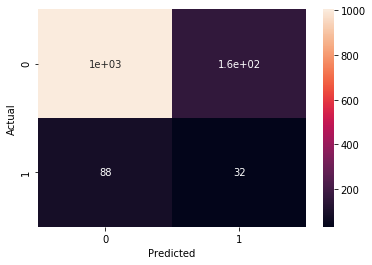

Confusion Matrix:
 [[1004  161]
 [  88   32]]
Accuracy Score: 0.8062256809338522
Precision Score: 0.8490378125869346
Recall Score: 0.8062256809338522
F1 Score: 0.8256886659299912


In [ ]:
y_true_str = data[metric_binary].tolist()
y_hat = final_labels
y_true =  list(map(int, y_true_str))



evaluation_rb.main(y_true,y_hat)

The confusion matrix clearly indicates that, number of statements with the label ‘No/0’ are greater than the number of statements with label ‘Yes/1’. The further evaluation includes 
different evaluation measurements like Accuracy, Precision, Recall and F1-score, to check the classification prediction task. Below are the results of this evaluation:



In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_true, y_pred=y_hat))

              precision    recall  f1-score   support

           0       0.92      0.86      0.89      1165
           1       0.17      0.27      0.20       120

    accuracy                           0.81      1285
   macro avg       0.54      0.56      0.55      1285
weighted avg       0.85      0.81      0.83      1285



In [ ]:
data[metric+' predicted'] = final_labels

In [ ]:
data.to_csv('data/business-performance-predicted.csv')

The above results show that this method achieved an 81% overall accuracy, 85% overall precision, and 81% overall Recall. Although this result looks convincing, there is a high imbalance in the class values of the label. There are only 120 statements with the label ‘Yes/1’ while 1083 statements are there with the label ‘No/0’. Therefore, it results in the low classification result in label ‘Yes/1’ while that is higher in label ‘No/0’ data.

# Testing with a sample


In [ ]:
data_sample = data.sample(10).reset_index(drop=True)

In [ ]:

extractions = [get_sentences_w_keywords(doc, few_keywords_lemmas) for doc in tqdm.tqdm(nlp.pipe(data_sample['TEXT']))]
extractions = [get_unique_sentences(dictionaries_list) for dictionaries_list in extractions]
data_sample['extractions'] = extractions

10it [00:01,  6.04it/s]


In [ ]:
data_sample['extractions']

0                                                   []
1    [{'element': 'performance indicator', 'sentenc...
2                                                   []
3                                                   []
4                                                   []
5                                                   []
6                                                   []
7                                                   []
8                                                   []
9                                                   []
Name: extractions, dtype: object

In [ ]:
data_sample['extractions'][1]

[{'element': 'performance indicator',
  'sentence': 'For instance, to hotels located near to high profile events such as the Super Bowl and the Olympics, where authorities report an increased risk of sex trafficking.Our Effectiveness and Performance Indicators',
  'span': '7602:7810',
  'tense': 'past'},
 {'element': 'performance indicator',
  'sentence': 'For instance, to hotels located near to high profile events such as the Super Bowl and the Olympics, where authorities report an increased risk of sex trafficking.Our Effectiveness and Performance Indicators“27,000+ colleagues completed our human rights training.”',
  'span': '7602:7868',
  'tense': 'past'},
 {'element': 'performance indicator',
  'sentence': 'Our Effectiveness and Performance Indicators“27,000+ colleagues completed our human rights training.”',
  'span': '7766:7868',
  'tense': 'past'}]